# Waterloo Takeoff Data Source Code

## Imports

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.colors import LinearSegmentedColormap


## File Readings and Dataframe Creation

In [48]:
%%time
# Flights from Apr 16 to May 23

subfolders = [f.path for f in os.scandir('data/waterloo/flight/') if f.is_dir()] #Scans Directory
total_subfolders = len(subfolders)

# Stores a csv cols into a list
df_time_list = []
df_kw_list = []
df_alt_list = []
df_soc_list = []
df_oat_list = []
df_pitch_list = []

# Iterates and read each csv
for i, subfolder in enumerate(subfolders):
    csv_files = glob.glob(os.path.join(subfolder, '*.csv'))
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True) #Status Print
    if csv_files:
        # Reads the first csv file in each flight folder
        main_csv = csv_files[0]
        with open(main_csv) as f:
            total_rows = sum(1 for line in f)
        # Skips every 10 rows for efficiency (1 sec iterations estimate)
        skip_rows = [i for i in range(1, total_rows) if i % 10 != 0]
    df_csv = pd.read_csv(main_csv,skiprows=skip_rows)
    df_time_list.append(df_csv[" time(min)"])
    df_kw_list.append(df_csv[" motor power"])
    df_soc_list.append(df_csv[" bat 1 soc"])
    df_oat_list.append(df_csv[" OAT"])
    df_pitch_list.append(df_csv[" PITCH"])
    # Calibrates alt to ground alt and converts m to ft
    df_csv[" PRESSURE_ALT"] = (df_csv[" PRESSURE_ALT"]-df_csv[" PRESSURE_ALT"].iloc[-1])*3.28084
    df_csv[" PRESSURE_ALT"] = df_csv[" PRESSURE_ALT"].where(df_csv[" PRESSURE_ALT"]>=0, 0)
    df_alt_list.append(df_csv[" PRESSURE_ALT"])
    
# Main df
df_power = pd.DataFrame({"time": df_time_list, "kw": df_kw_list, "alt": df_alt_list, "soc": df_soc_list, "oat": df_oat_list, "pitch": df_pitch_list})
print('') 

Processing file data/waterloo/flight/csv-24758-5821 [2%]

Processing file data/waterloo/flight/csv-26027-6253 [100%]
CPU times: total: 4.67 s
Wall time: 12.3 s


## Data Visualizations

### Altitude Data From All Flights

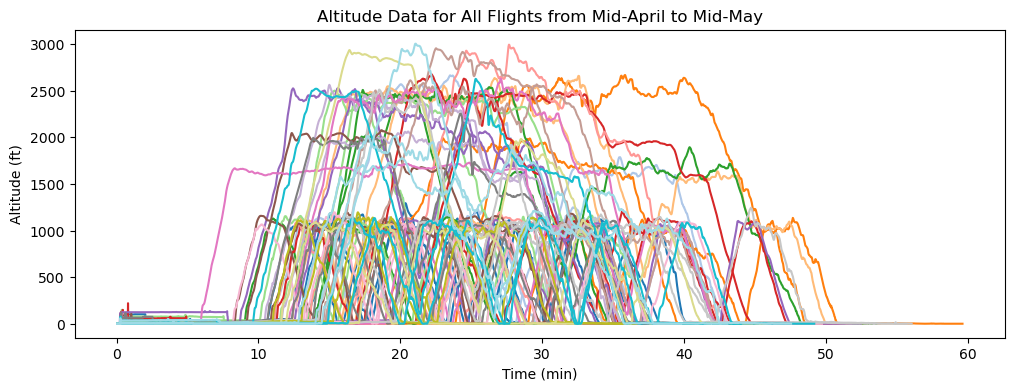

CPU times: total: 188 ms
Wall time: 463 ms


In [49]:
%%time
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))
for i, subfolder in enumerate(subfolders):
    plt.plot(df_power["time"][i], df_power["alt"][i],color=colormap(i / total_subfolders))
    #plt.plot(df_power["kw"][i])

plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude Data for All Flights from Mid-April to Mid-May')
plt.show()

### Circuit-Fitlered Altitude Data

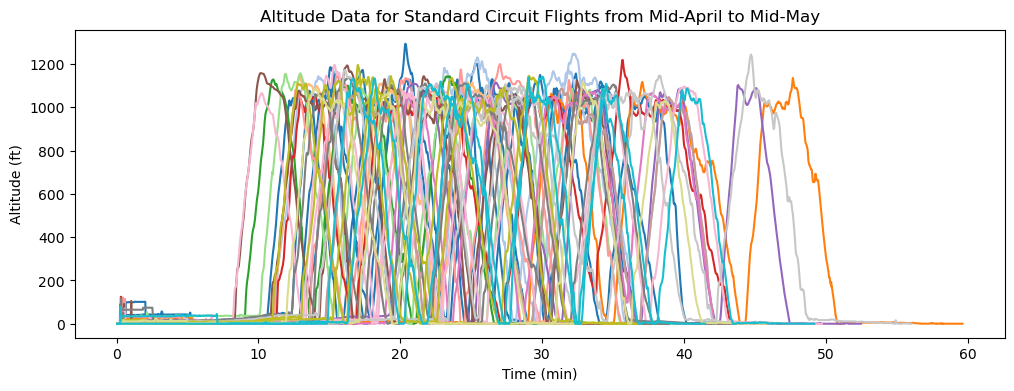

CPU times: total: 125 ms
Wall time: 400 ms


In [50]:
%%time
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))
for i, subfolder in enumerate(subfolders):
    if df_power["alt"][i].max() < 1300:
        plt.plot(df_power["time"][i], df_power["alt"][i],color=colormap(i / total_subfolders))


plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()

### Takeoff-Filtered Altitude Data

Processing file data/waterloo/flight/csv-26027-6253 [100%]
Average Slope of Altitude per Time: 626.189 ft/min
Average Slope of Time per Altitude: 0.6 min/300 ft
Plotting...


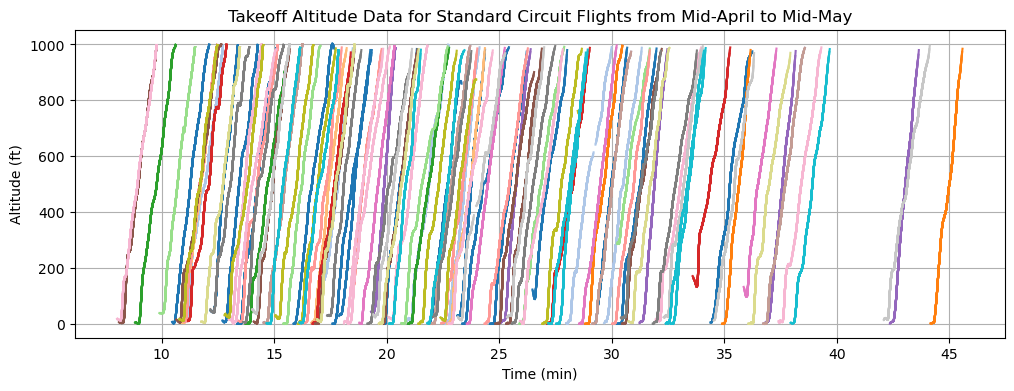

CPU times: total: 9.02 s
Wall time: 18 s


In [51]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_ft_per_min = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                # Stops indexing at 1000 when end index is greater than 1000
                if df_power["alt"][i][end_idx] > 1000:
                    end_idx = np.argmax(df_power["alt"][i] > 1000)
                alt_data = df_power["alt"][i][start_idx:end_idx]
                time_data = df_power["time"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

                # Finds average slope
                diff_alt_data = np.diff(alt_data)
                diff_time_data = np.diff(time_data)
                valid_indices = np.where(diff_time_data != 0)[0]
                slope_ft_per_min = diff_alt_data[valid_indices] / diff_time_data[valid_indices]
                slopes_ft_per_min.extend(slope_ft_per_min)

print('')
average_slope_ft_per_min = abs(np.mean(slopes_ft_per_min))
print(f"Average Slope of Altitude per Time: {round(average_slope_ft_per_min,3)} ft/min")
print(f"Average Slope of Time per Altitude: {round(1/average_slope_ft_per_min,3)*300} min/300 ft")
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('Altitude (ft)')
plt.title('Takeoff Altitude Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.grid(True)
plt.show()


Processing file data/waterloo/flight/csv-26027-6253 [100%]
Average Slope of Min per 300 ft: 0.459 min/300 ft
Plotting...


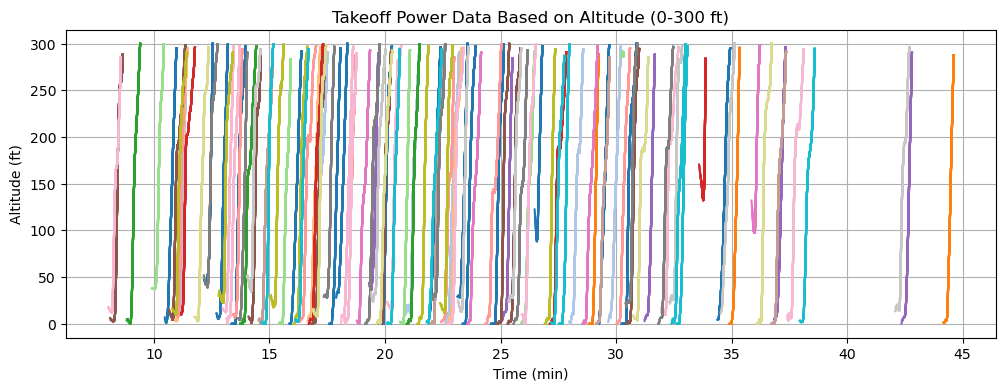

CPU times: total: 6.56 s
Wall time: 9.39 s


In [52]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []
time_sum = [0,0,0]

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 400
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 0:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 300:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                time_data = df_power["time"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])/(df_power["time"][i][start_idx]-df_power["time"][i][end_idx])))

print('')
average_slope_soc_per_ft = round(1/(abs(np.mean(slopes_list)))*300,3)
time_sum[0] = average_slope_soc_per_ft
print(f"Average Slope of Min per 300 ft: {average_slope_soc_per_ft} min/300 ft")
print("Plotting...")
plt.ylabel('Altitude (ft)')
plt.xlabel('Time (min)')
plt.title('Takeoff Power Data Based on Altitude (0-300 ft)')
plt.grid(True)
plt.show()


Processing file data/waterloo/flight/csv-24758-5821 [2%]

Processing file data/waterloo/flight/csv-26027-6253 [100%]
Average Slope of Min per 300 ft: 0.464 min/300 ft
Plotting...


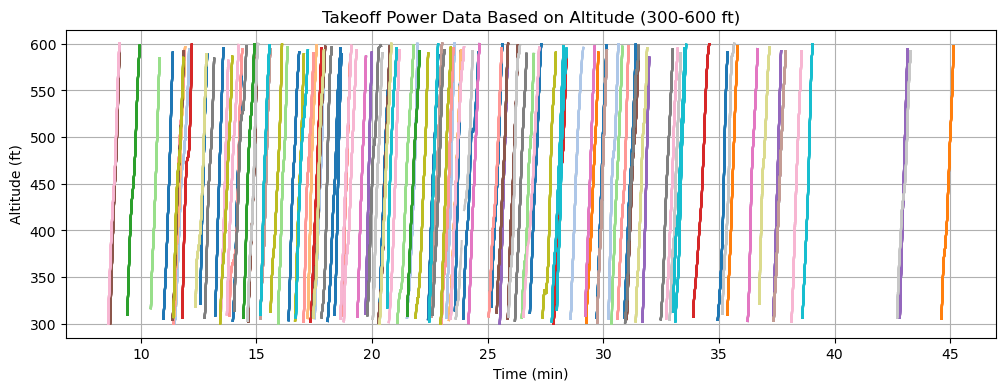

CPU times: total: 7.97 s
Wall time: 10.8 s


In [53]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 300:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 600:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                time_data = df_power["time"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])/(df_power["time"][i][start_idx]-df_power["time"][i][end_idx])))

print('')
average_slope_soc_per_ft = round(1/(abs(np.mean(slopes_list)))*300,3)
time_sum[1] = average_slope_soc_per_ft
print(f"Average Slope of Min per 300 ft: {average_slope_soc_per_ft} min/300 ft")
print("Plotting...")
plt.ylabel('Altitude (ft)')
plt.xlabel('Time (min)')
plt.title('Takeoff Power Data Based on Altitude (300-600 ft)')
plt.grid(True)
plt.show()


Processing file data/waterloo/flight/csv-26027-6253 [100%]
Average Slope of Min per 300 ft: 0.476 min/300 ft
Plotting...


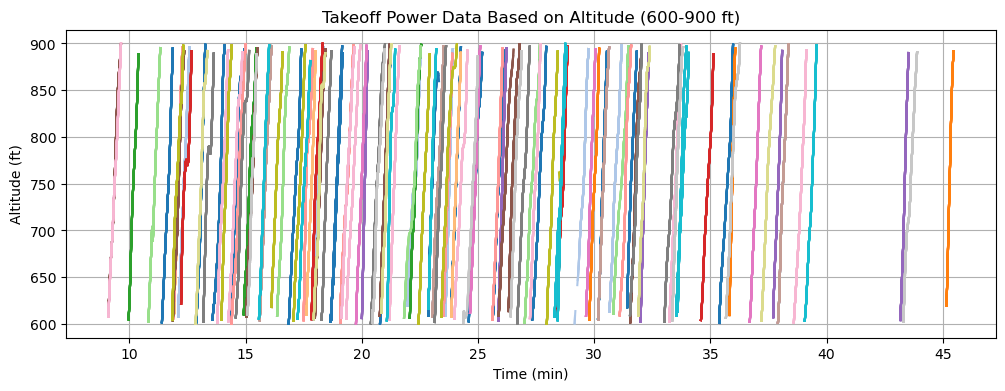

CPU times: total: 8.05 s
Wall time: 10.6 s


In [54]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 600:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 900:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                time_data = df_power["time"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])/(df_power["time"][i][start_idx]-df_power["time"][i][end_idx])))

print('')
average_slope_soc_per_ft = round(1/(abs(np.mean(slopes_list)))*300,3)
time_sum[2] = average_slope_soc_per_ft
print(f"Average Slope of Min per 300 ft: {average_slope_soc_per_ft} min/300 ft")
print("Plotting...")
plt.ylabel('Altitude (ft)')
plt.xlabel('Time (min)')
plt.title('Takeoff Power Data Based on Altitude (600-900 ft)')
plt.grid(True)
plt.show()


### Takeoff Power Data

Processing file data/waterloo/flight/csv-26027-6253 [100%]
Plotting...


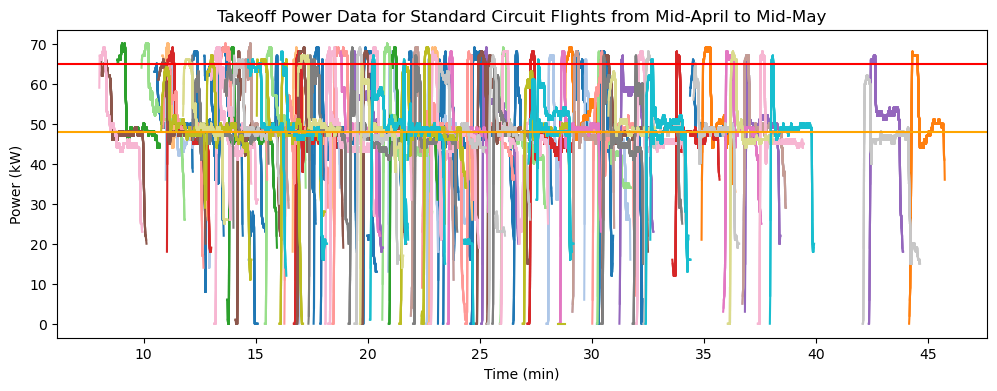

CPU times: total: 12.9 s
Wall time: 15.2 s


In [55]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["time"][i][start_idx:end_idx]
                alt_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")

plt.axhline(y=65, color='r')
plt.axhline(y=48, color='orange')
plt.xlabel('Time (min)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


Processing file data/waterloo/flight/csv-26027-6253 [100%]
Plotting...


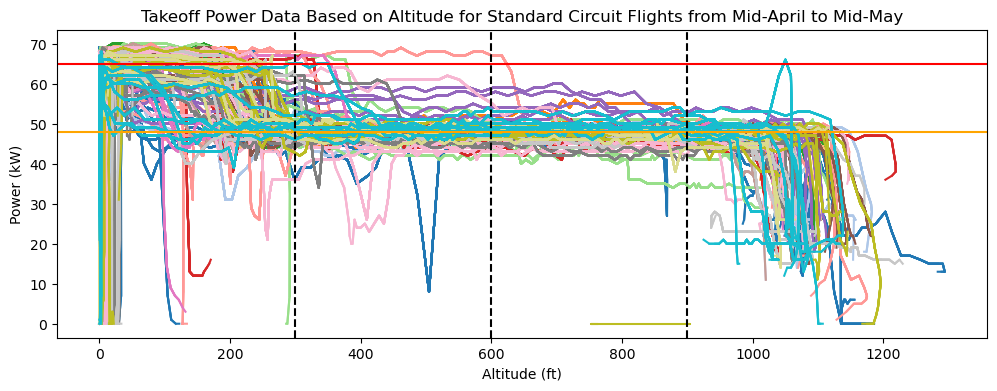

CPU times: total: 13.2 s
Wall time: 15.5 s


In [56]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["alt"][i][start_idx:end_idx]
                alt_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")

plt.axhline(y=65, color='r')
plt.axhline(y=48, color='orange')
plt.axvline(x=300, color='black', linestyle='--')
plt.axvline(x=600, color='black', linestyle='--')
plt.axvline(x=900, color='black', linestyle='--')
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


Processing file data/waterloo/flight/csv-26027-6253 [100%]
Average Slope of Min per 300 ft: 60.154 kW
Plotting...


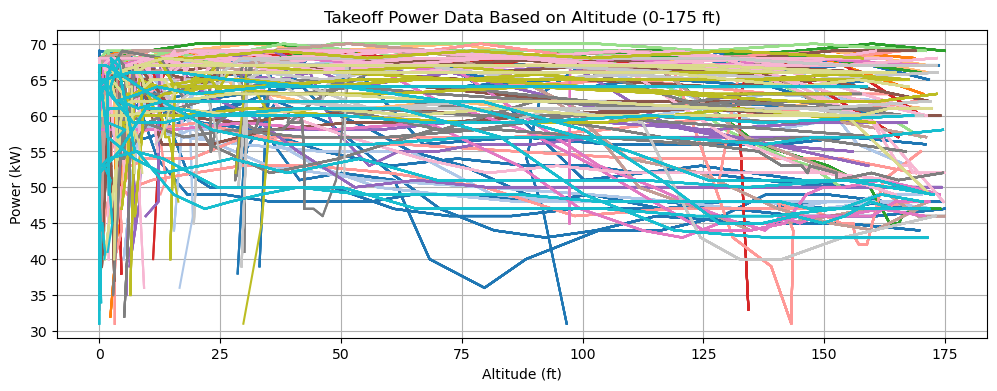

CPU times: total: 4.91 s
Wall time: 10.5 s


In [57]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
power_list = []


for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 0:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 175:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                pwr_data = df_power["kw"][i][start_idx:end_idx]
                filtered_pwr = df_power["kw"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx]>30]
                filtered_alt = df_power["alt"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx]>30]
                plt.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))
                
                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                power_list.append(filtered_pwr.mean())
print('')
average_power = round((abs(np.mean(power_list))),3)
print(f"Average Slope of Min per 300 ft: {round((average_power),3)} kW")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude (0-175 ft)')
plt.grid(True)
plt.show()


Processing file data/waterloo/flight/csv-26027-6253 [100%]
Average Slope of Min per 300 ft: 52.105 kW
Plotting...


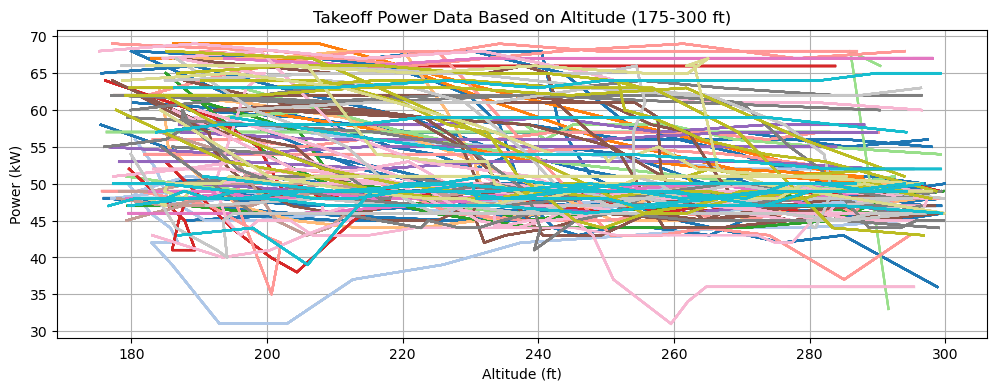

CPU times: total: 6.36 s
Wall time: 11.7 s


In [58]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
power_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 175:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 300:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                pwr_data = df_power["kw"][i][start_idx:end_idx]
                filtered_pwr = df_power["kw"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx]>30]
                filtered_alt = df_power["alt"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx]>30]
                plt.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))
                
                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                power_list.append(filtered_pwr.mean())
print('')
average_power = round((abs(np.mean(power_list))),3)
print(f"Average Slope of Min per 300 ft: {round((average_power),3)} kW")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude (175-300 ft)')
plt.grid(True)
plt.show()


Processing file data/waterloo/flight/csv-26027-6253 [100%]
Average Slope of Min per 300 ft: 54.544 kW
Plotting...


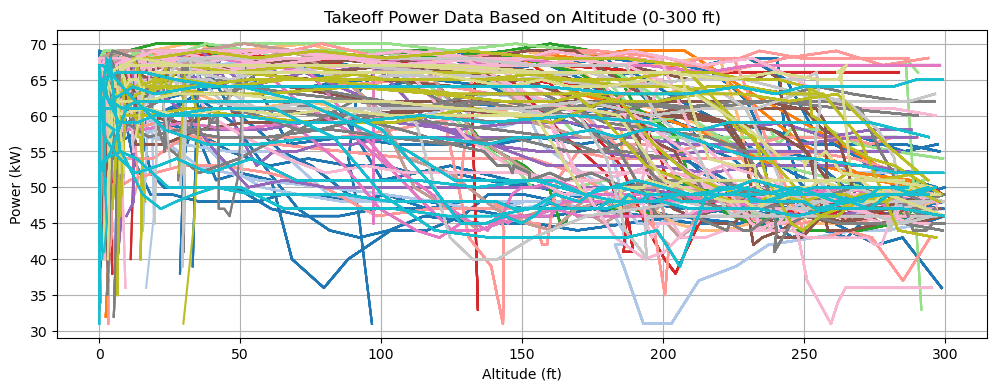

CPU times: total: 6.73 s
Wall time: 11.6 s


In [59]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
power_list = []
power_sum = [0,0,0]

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 0:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 300:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                filtered_pwr = df_power["kw"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx]>30]
                filtered_alt = df_power["alt"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx]>30]
                
                plt.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                power_list.append(filtered_pwr.mean())
print('')
average_power = round((abs(np.mean(power_list))),3)
power_sum[0] = average_power
print(f"Average Slope of Min per 300 ft: {round((average_power),3)} kW")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude (0-300 ft)')
plt.grid(True)
plt.show()



Processing file data/waterloo/flight/csv-26027-6253 [100%]
Average Slope of Min per 300 ft: 48.388 kW
Plotting...


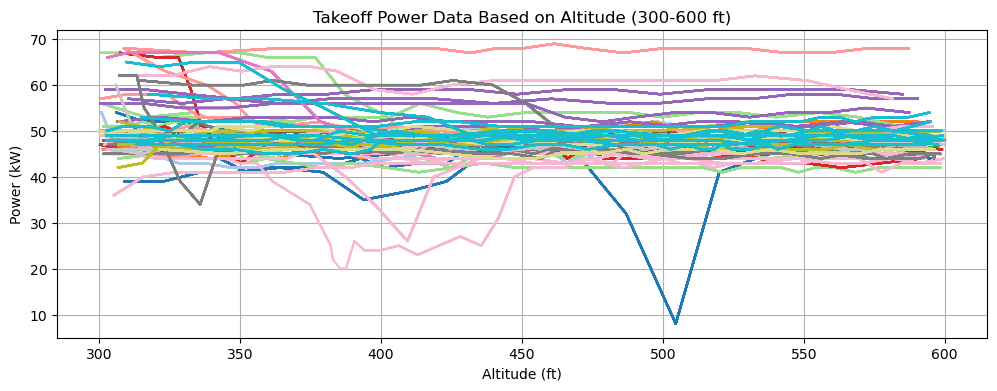

CPU times: total: 5.95 s
Wall time: 11.7 s


In [60]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
power_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 300:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 600:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                pwr_data = df_power["kw"][i][start_idx:end_idx]
                plt.plot(alt_data, pwr_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                power_list.append(df_power["kw"][i][start_idx:end_idx].mean())
print('')
average_power = round((abs(np.mean(power_list))),3)
power_sum[1] = average_power
print(f"Average Slope of Min per 300 ft: {round((average_power),3)} kW")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude (300-600 ft)')
plt.grid(True)
plt.show()


Processing file data/waterloo/flight/csv-26027-6253 [100%]
Average Slope of Min per 300 ft: 47.642 kW
Plotting...


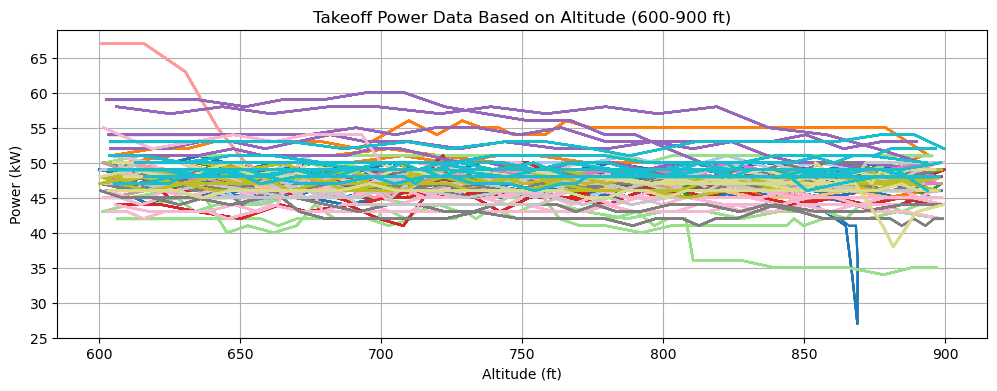

CPU times: total: 10.1 s
Wall time: 15.3 s


In [61]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
power_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 600:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 900:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                
                filtered_pwr = df_power["kw"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx]>10]
                filtered_alt = df_power["alt"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx]>10]
                plt.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                power_list.append(df_power["kw"][i][start_idx:end_idx].mean())
print('')
average_power = round((abs(np.mean(power_list))),3)
power_sum[2] = average_power
print(f"Average Slope of Min per 300 ft: {round((average_power),3)} kW")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('Power (kW)')
plt.title('Takeoff Power Data Based on Altitude (600-900 ft)')
plt.grid(True)
plt.show()


#### Power Seperated by OAT

Processing file data/waterloo/flight/csv-26027-6253 [100%]
Average Power (OAT > 20°): 54.346 kW
Average Power (17.5°-20°): 54.225 kW
Average Power (15°-17.5°): 54.848 kW
Average Power (OAT < 15°): 54.889 kW
Plotting...


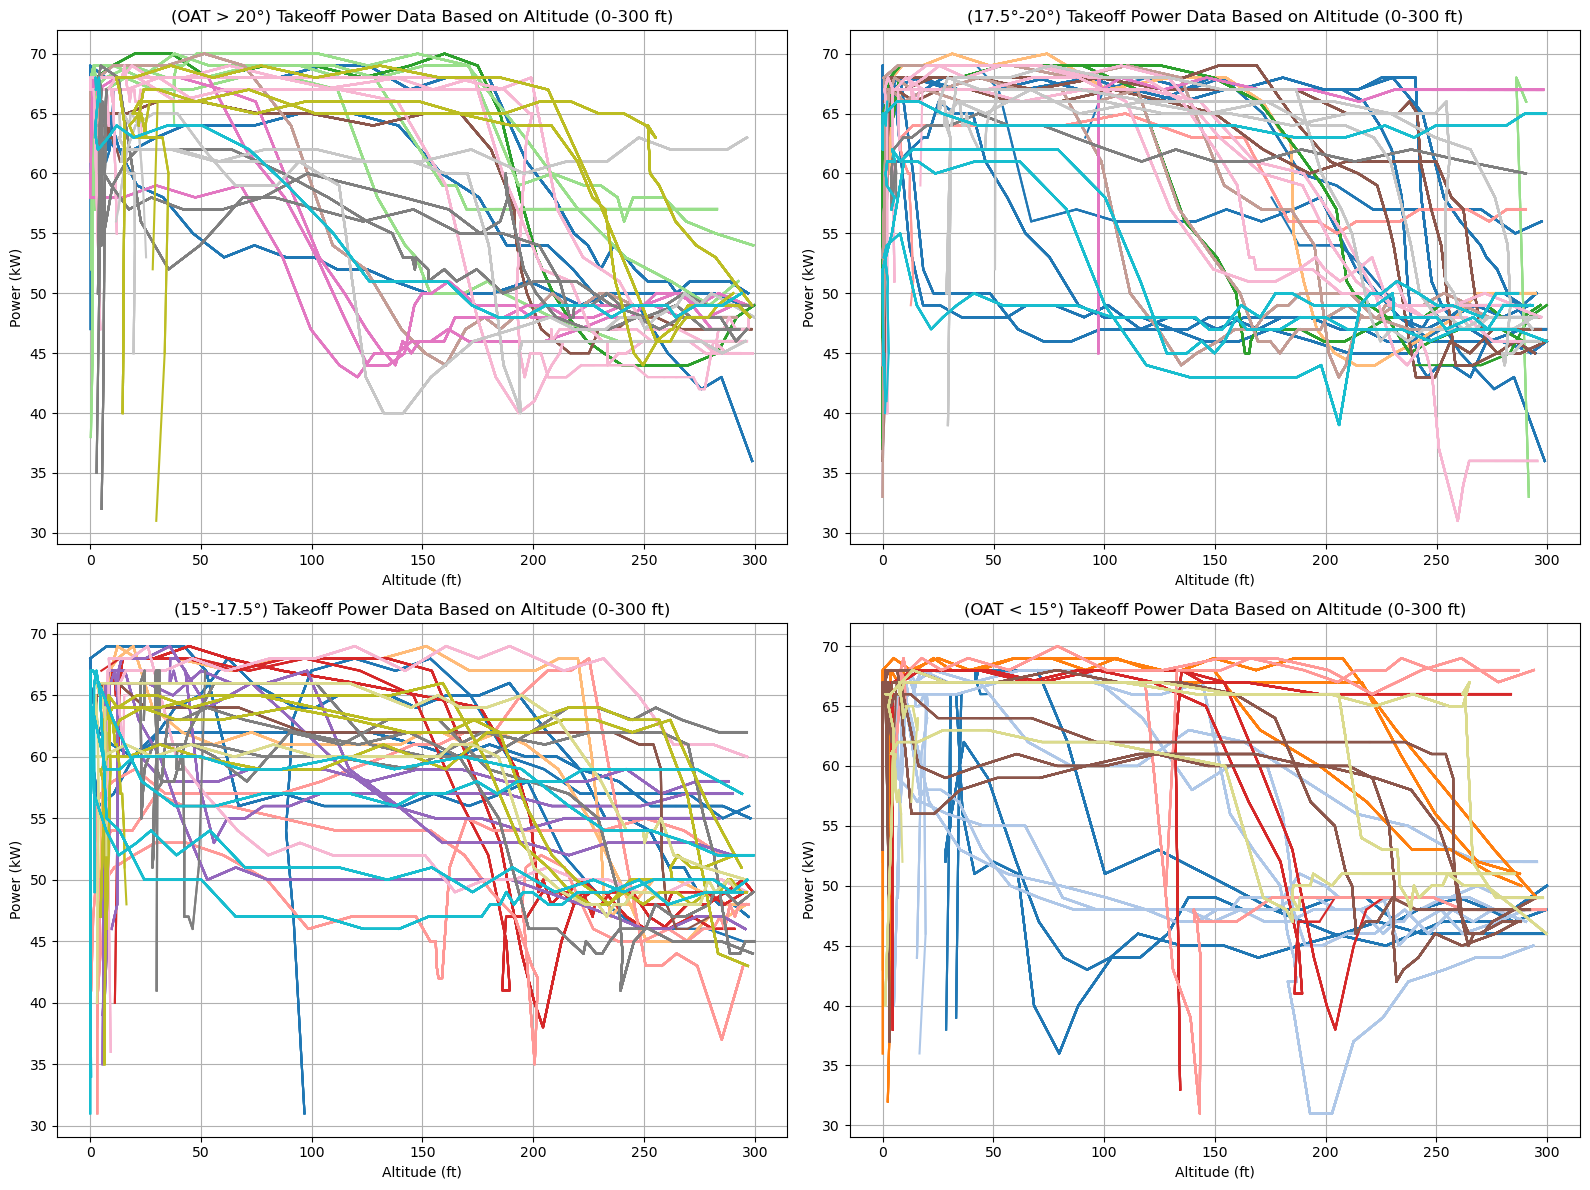

CPU times: total: 9.39 s
Wall time: 14.9 s


In [62]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']

slopes_soc_per_ft = []
power_list_1 = []
power_list_2 = []
power_list_3 = []
power_list_4 = []
powers = [0,0,0,0]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
(ax1, ax2), (ax3, ax4) = axes

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush=True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 20 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index

        if not high_slope_indices.empty:
            # Plots the data in between data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)

                while start_idx < end_idx and df_power["alt"][i][start_idx] < 0:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 300:
                    end_idx -= 1

                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue

                filtered_pwr = df_power["kw"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx] > 30]
                filtered_alt = df_power["alt"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx] > 30]
                filtered_oat = df_power["oat"][i][start_idx:end_idx][df_power["kw"][i][start_idx:end_idx] > 30]

                mean_oat = np.mean(filtered_oat)
                if mean_oat > 20:
                    ax1.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))
                    power_list_1.append(filtered_pwr.mean())
                elif 17.5 <= mean_oat <= 20:
                    ax2.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))
                    power_list_2.append(filtered_pwr.mean())
                elif 15 <= mean_oat < 17.5:
                    ax3.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))
                    power_list_3.append(filtered_pwr.mean())
                elif mean_oat < 15:
                    ax4.plot(filtered_alt, filtered_pwr, color=colormap(i / total_subfolders))
                    power_list_4.append(filtered_pwr.mean())

print('')
average_power_1 = round((abs(np.mean(power_list_1))), 3)
average_power_2 = round((abs(np.mean(power_list_2))), 3)
average_power_3 = round((abs(np.mean(power_list_3))), 3)
average_power_4 = round((abs(np.mean(power_list_4))), 3)
powers[0] = average_power_1
powers[1] = average_power_2
powers[2] = average_power_3
powers[3] = average_power_4

print(f"Average Power (OAT > 20°): {average_power_1} kW")
print(f"Average Power (17.5°-20°): {average_power_2} kW")
print(f"Average Power (15°-17.5°): {average_power_3} kW")
print(f"Average Power (OAT < 15°): {average_power_4} kW")
print("Plotting...")

# Configure the subplots
ax1.set_xlabel('Altitude (ft)')
ax1.set_ylabel('Power (kW)')
ax1.set_title('(OAT > 20°) Takeoff Power Data Based on Altitude (0-300 ft)')
ax1.grid(True)

ax2.set_xlabel('Altitude (ft)')
ax2.set_ylabel('Power (kW)')
ax2.set_title('(17.5°-20°) Takeoff Power Data Based on Altitude (0-300 ft)')
ax2.grid(True)

ax3.set_xlabel('Altitude (ft)')
ax3.set_ylabel('Power (kW)')
ax3.set_title('(15°-17.5°) Takeoff Power Data Based on Altitude (0-300 ft)')
ax3.grid(True)

ax4.set_xlabel('Altitude (ft)')
ax4.set_ylabel('Power (kW)')
ax4.set_title('(OAT < 15°) Takeoff Power Data Based on Altitude (0-300 ft)')
ax4.grid(True)

plt.tight_layout()
plt.show()

### Takeoff SoC Data

Processing file data/waterloo/flight/csv-26027-6253 [100%]
Plotting...


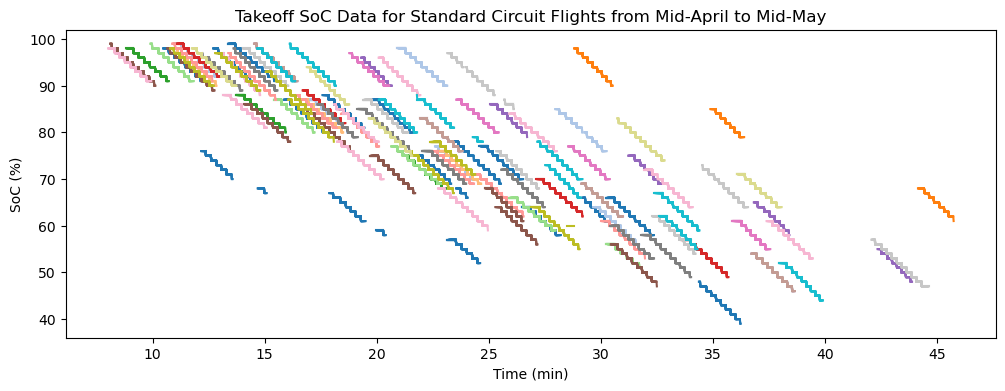

CPU times: total: 12.4 s
Wall time: 14.7 s


In [63]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
    
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                time_data = df_power["time"][i][start_idx:end_idx]
                alt_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(time_data, alt_data, color=colormap(i / total_subfolders))

print('')
print("Plotting...")
plt.xlabel('Time (min)')
plt.ylabel('SoC (%)')
plt.title('Takeoff SoC Data for Standard Circuit Flights from Mid-April to Mid-May')
plt.show()


Processing file data/waterloo/flight/csv-26027-6253 [100%]
Average Slope of SoC per Altitude: 8.91%/1000 ft
Plotting...


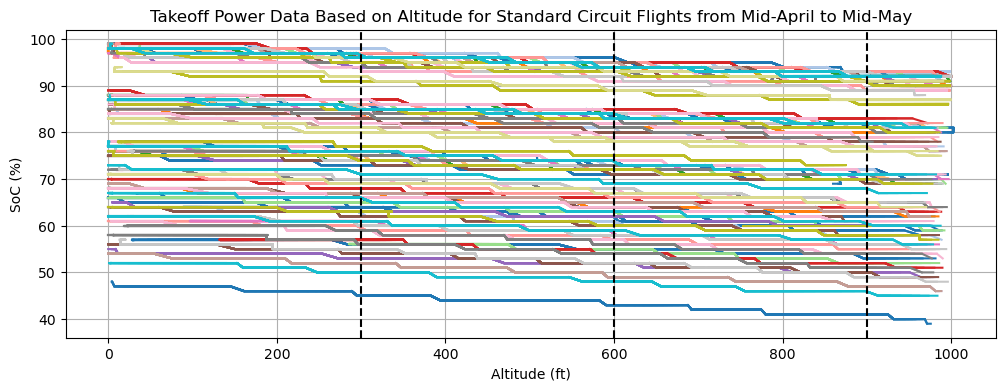

[]
CPU times: total: 13.5 s
Wall time: 17.3 s


In [64]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                if df_power["alt"][i][end_idx] > 1000:
                    end_idx = np.argmax(df_power["alt"][i] > 1000)
                alt_data = df_power["alt"][i][start_idx:end_idx]
                soc_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(alt_data, soc_data, color=colormap(i / total_subfolders))

                diff_soc_data = np.diff(soc_data)
                diff_alt_data = np.diff(alt_data)
                valid_indices = np.where(diff_alt_data != 0)[0]
                slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                slopes_soc_per_ft.extend(slope_soc_per_ft)
               
                

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_soc_per_ft))*1000
print(f"Average Slope of SoC per Altitude: {round(average_slope_soc_per_ft,3)}%/1000 ft")
print("Plotting...")
plt.axvline(x=300, color='black', linestyle='--')
plt.axvline(x=600, color='black', linestyle='--')
plt.axvline(x=900, color='black', linestyle='--')
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude for Standard Circuit Flights from Mid-April to Mid-May')
plt.grid(True)
plt.show()
print(slopes_list)


Processing file data/waterloo/flight/csv-24758-5821 [2%]

Processing file data/waterloo/flight/csv-26027-6253 [100%]
Average Slope of SoC per Altitude: 2.03%/300 ft
Plotting...


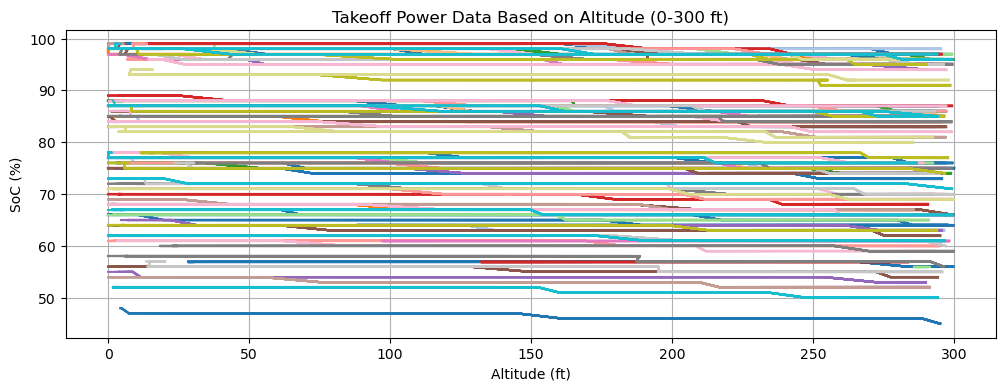

CPU times: total: 7.66 s
Wall time: 9.31 s


In [65]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 0:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 300:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
                
                alt_data = df_power["alt"][i][start_idx:end_idx]
                soc_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(alt_data, soc_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["soc"][i][start_idx]-df_power["soc"][i][end_idx])/(df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])))
                
                

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_list))*300 
print(f"Average Slope of SoC per Altitude: {round(average_slope_soc_per_ft,3)}%/300 ft")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude (0-300 ft)')
plt.grid(True)
plt.show()


Processing file data/waterloo/flight/csv-26027-6253 [100%]
Average Slope of SoC per Altitude: 2.231%/300 ft
Plotting...


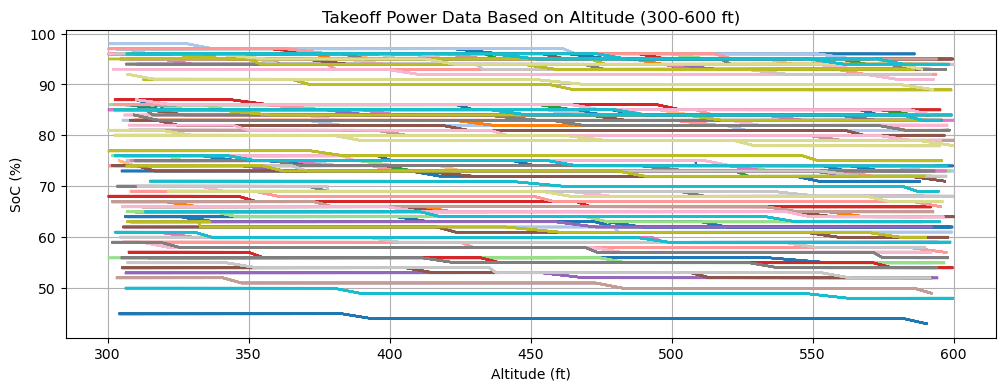

CPU times: total: 9.34 s
Wall time: 11.2 s


In [66]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 300:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 600:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                soc_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(alt_data, soc_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["soc"][i][start_idx]-df_power["soc"][i][end_idx])/(df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])))

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_list))*300
print(f"Average Slope of SoC per Altitude: {round(average_slope_soc_per_ft,3)}%/300 ft")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude (300-600 ft)')
plt.grid(True)
plt.show()


Processing file data/waterloo/flight/csv-26027-6253 [100%]
Average Slope of SoC per Altitude: 2.199%/300 ft
Plotting...


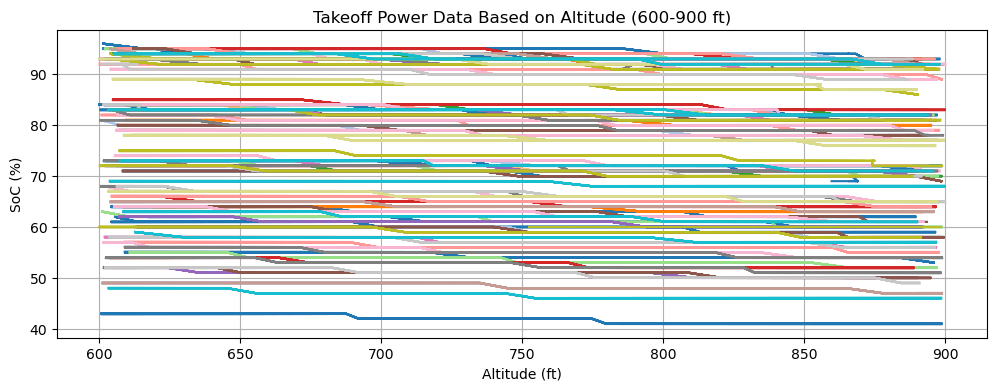

CPU times: total: 9.11 s
Wall time: 10.7 s


In [67]:
%%time
cell_diff = 20
total_subfolders = len(subfolders)
colormap = plt.colormaps['tab20']
plt.figure(figsize=(12, 4))

slopes_soc_per_ft = []
slopes_list = []

for i, subfolder in enumerate(subfolders):
    print(f"\rProcessing file {subfolder} [{round((i+1) / total_subfolders * 100)}%]", end='', flush = True)
    if df_power["alt"][i].max() < 1300:
        # Calculates the slope of cells 100 cells away from each other
        alt_diff = df_power["alt"][i].diff(periods=cell_diff)
        time_diff = df_power["time"][i].diff(periods=cell_diff)
        temp_alt_diff = df_power["alt"][i].diff(periods=10)
        alt_diff[temp_alt_diff < 0] = 0
        slope = alt_diff / time_diff 
        # Find the indices where slope is over 450
        high_slope_indices = slope[slope > 400].index
    
        if not high_slope_indices.empty:
            # Plots the data inbtwn data sufficient slope
            for idx in high_slope_indices:
                start_idx = max(0, idx - cell_diff + 1)
                end_idx = min(len(df_power["alt"][i]), idx + 1)
                
                while start_idx < end_idx and df_power["alt"][i][start_idx] < 600:
                    start_idx += 1
                while end_idx > start_idx and df_power["alt"][i][end_idx - 1] > 900:
                    end_idx -= 1
                
                if start_idx == end_idx:
                    # No valid altitude values within the range
                    continue
            
                alt_data = df_power["alt"][i][start_idx:end_idx]
                soc_data = df_power["soc"][i][start_idx:end_idx]
                plt.plot(alt_data, soc_data, color=colormap(i / total_subfolders))

                # diff_soc_data = np.diff(soc_data)
                # diff_alt_data = np.diff(alt_data)
                # valid_indices = np.where(diff_alt_data != 0)[0]
                # slope_soc_per_ft = diff_soc_data[valid_indices] / diff_alt_data[valid_indices]
                # slopes_soc_per_ft.extend(slope_soc_per_ft)
                
                slopes_list.append(abs((df_power["soc"][i][start_idx]-df_power["soc"][i][end_idx])/(df_power["alt"][i][start_idx]-df_power["alt"][i][end_idx])))

print('')
average_slope_soc_per_ft = abs(np.mean(slopes_list))*300
print(f"Average Slope of SoC per Altitude: {round(average_slope_soc_per_ft,3)}%/300 ft")
print("Plotting...")
plt.xlabel('Altitude (ft)')
plt.ylabel('SoC (%)')
plt.title('Takeoff Power Data Based on Altitude (600-900 ft)')
plt.grid(True)
plt.show()


### Average Total Energy Consumption

In [68]:
time_list = np.array(time_sum)
pwr_list = np.array(power_sum)
kWh_list = time_list*pwr_list/60
total_kWh = round((np.sum(kWh_list)),3)
print(f"Time per 300 ft:{time_list} min")
print(f"Average Power per 300 ft:{pwr_list} kW")
print(f"Divided Energy: {np.round(kWh_list,3)} kWh")
print(f"Total Energy: {total_kWh} kWh")
print(f"dSoC (At 75% SoH): {round((total_kWh/(24.8*0.75))*100,3)}%")

Time per 300 ft:[0.459 0.464 0.476] min
Average Power per 300 ft:[54.544 48.388 47.642] kW
Divided Energy: [0.417 0.374 0.378] kWh
Total Energy: 1.169 kWh
dSoC (At 75% SoH): 6.285%
